In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
!pip install rasterio opencv-python scikit-image matplotlib

In [3]:
!apt-get update && apt-get install -y build-essential

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cli.github.com/packages stable/main amd64 Packages [357 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [85.0 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,910 kB]
Get:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,301 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Ge

In [4]:
!apt-get update && apt-get install -y libgdal-dev

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgdal-dev is already the newest version (3.8.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed

In [6]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [9]:
path = '/content/drive/MyDrive/Delete/'
dem_file = os.path.join(path,  'DEM.tif')
with rasterio.open(dem_file) as src:
    dem = src.read(1)
    profile = src.profile

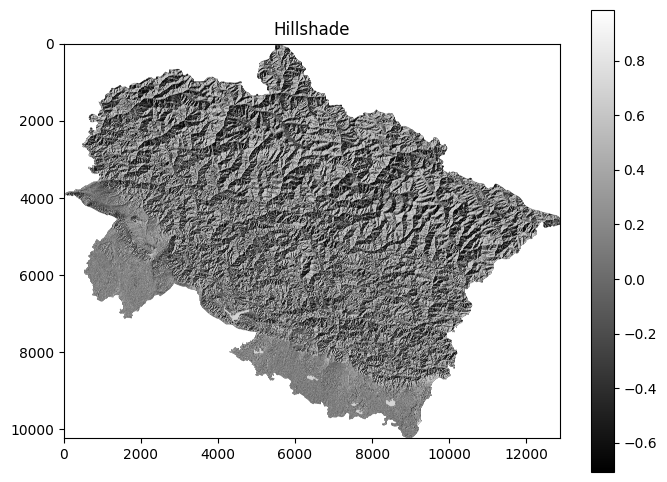

In [10]:
from scipy.ndimage import sobel

def compute_hillshade(dem, azimuth=315, altitude=45):
    azimuth_rad = np.radians(360 - azimuth + 90)
    altitude_rad = np.radians(altitude)
    dx = sobel(dem, axis=1)
    dy = sobel(dem, axis=0)
    slope = np.arctan(np.sqrt(dx**2 + dy**2))
    aspect = np.arctan2(-dy, dx)
    hillshade = (np.sin(altitude_rad) * np.cos(slope) +
                 np.cos(altitude_rad) * np.sin(slope) * np.cos(azimuth_rad - aspect))
    return hillshade

hillshade = compute_hillshade(dem)

plt.figure(figsize=(8,6))
plt.imshow(hillshade, cmap='gray')
plt.title("Hillshade")
plt.colorbar()
plt.show()

/tmp/ipython-input-731414675.py:4: RuntimeWarning: invalid value encountered in cast
  hillshade_norm = hillshade_norm.astype(np.uint8)


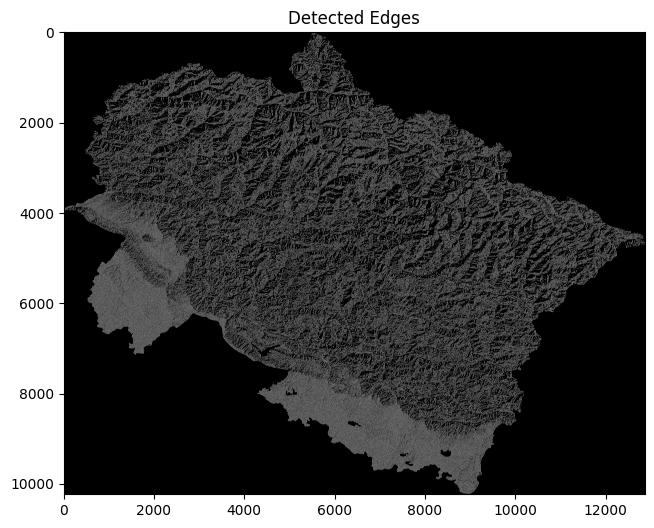

In [11]:
# Normalize hillshade to 0-255
hillshade_clipped = np.clip(hillshade, 0, 1)
hillshade_norm = cv2.normalize(hillshade_clipped, None, 0, 255, cv2.NORM_MINMAX)
hillshade_norm = hillshade_norm.astype(np.uint8)

edges = cv2.Canny(hillshade_norm, 50, 150)

plt.figure(figsize=(8,6))
plt.imshow(edges, cmap='gray')
plt.title("Detected Edges")
plt.show()

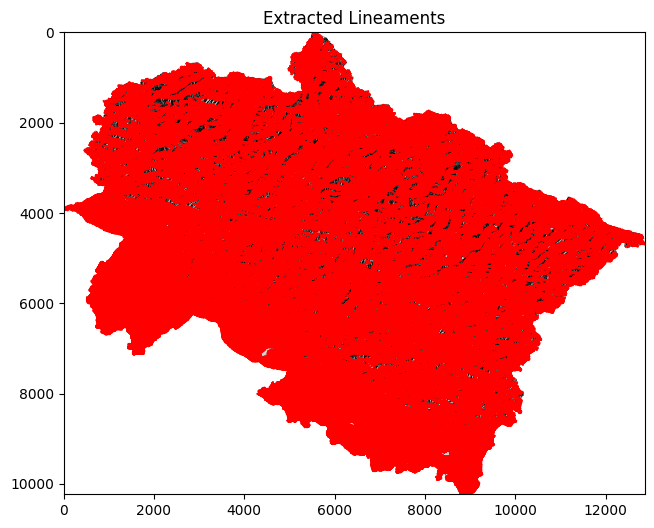

In [12]:
lines = cv2.HoughLinesP(edges,
                        rho=1,
                        theta=np.pi/180,
                        threshold=100,
                        minLineLength=50,
                        maxLineGap=10)

# Plot lineaments
plt.figure(figsize=(8,6))
plt.imshow(hillshade, cmap='gray')

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        plt.plot([x1, x2], [y1, y2], 'r')

plt.title("Extracted Lineaments")
plt.show()

In [13]:
output_file = os.path.join(path, "lineaments.tif")

with rasterio.open(output_file, 'w', **profile) as dst:
    dst.write(edges, 1)